In [91]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
import xgboost as xgb
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler, 
    OneHotEncoder,
    OrdinalEncoder
)
import mlflow as mf
from sklearn.pipeline import Pipeline, FeatureUnion

from feature_engine.encoding import CountFrequencyEncoder


In [74]:
# Loading the data
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("Dataset\Airline Dataset Updated - v2.csv")
df.head(5)

,Passenger ID,First Name,Last Name,Gender,Age,Nationality,Airport Name,Airport Country Code,Country Name,Airport Continent,Continents,Departure Date,Arrival Airport,Pilot Name,Flight Status
0,ABVWIg,Edithe,Leggis,Female,62,Japan,Coldfoot Airport,US,United States,NAM,North America,6/28/2022,CXF,Fransisco Hazeldine,On Time
1,jkXXAX,Elwood,Catt,Male,62,Nicaragua,Kugluktuk Airport,CA,Canada,NAM,North America,12/26/2022,YCO,Marla Parsonage,On Time
2,CdUz2g,Darby,Felgate,Male,67,Russia,Grenoble-Isère Airport,FR,France,EU,Europe,1/18/2022,GNB,Rhonda Amber,On Time
3,BRS38V,Dominica,Pyle,Female,71,China,Ottawa / Gatineau Airport,CA,Canada,NAM,North America,9/16/2022,YND,Kacie Commucci,Delayed
4,9kvTLo,Bay,Pencost,Male,21,China,Gillespie Field,US,United States,NAM,North America,2/25/2022,SEE,Ebonee Tree,On Time


In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98619 entries, 0 to 98618
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Passenger ID          98619 non-null  object
 1   First Name            98619 non-null  object
 2   Last Name             98619 non-null  object
 3   Gender                98619 non-null  object
 4   Age                   98619 non-null  int64 
 5   Nationality           98619 non-null  object
 6   Airport Name          98619 non-null  object
 7   Airport Country Code  98619 non-null  object
 8   Country Name          98619 non-null  object
 9   Airport Continent     98619 non-null  object
 10  Continents            98619 non-null  object
 11  Departure Date        98619 non-null  object
 12  Arrival Airport       98619 non-null  object
 13  Pilot Name            98619 non-null  object
 14  Flight Status         98619 non-null  object
dtypes: int64(1), object(14)
memory usage

In [76]:
df['Departure Date'][:1200]

0        6/28/2022
1       12/26/2022
2        1/18/2022
3        9/16/2022
4        2/25/2022
           ...    
1195    09-05-2022
1196     6/22/2022
1197    09-10-2022
1198    03-01-2022
1199    04-04-2022
Name: Departure Date, Length: 1200, dtype: object

In [77]:
def parse_date(date_str):
    try:
        return pd.to_datetime(date_str, format="%m/%d/%Y")  # Try MM/DD/YYYY
    except ValueError:
        try:
            return pd.to_datetime(date_str, format="%m-%d-%Y")  # Try MM-DD-YYYY
        except ValueError:
            return pd.to_datetime(date_str, errors='coerce')  # If all fail, return NaT
df['Departure Date'] = df['Departure Date'].apply(parse_date)


In [78]:
# Which months had the highest number of flights?

df.head(5)
df['Year of Depature'] = df['Departure Date'].dt.year
df['Month of Depature'] = df['Departure Date'].dt.month
df['Day of Depature'] = df['Departure Date'].dt.day

In [79]:
df.drop(columns=['Passenger ID' , "First Name" , "Last Name" , "Departure Date" , "Pilot Name"] , inplace= True)

In [80]:
df.shape

(98619, 13)

In [81]:
df.head()

,Gender,Age,Nationality,Airport Name,Airport Country Code,Country Name,Airport Continent,Continents,Arrival Airport,Flight Status,Year of Depature,Month of Depature,Day of Depature
0,Female,62,Japan,Coldfoot Airport,US,United States,NAM,North America,CXF,On Time,2022,6,28
1,Male,62,Nicaragua,Kugluktuk Airport,CA,Canada,NAM,North America,YCO,On Time,2022,12,26
2,Male,67,Russia,Grenoble-Isère Airport,FR,France,EU,Europe,GNB,On Time,2022,1,18
3,Female,71,China,Ottawa / Gatineau Airport,CA,Canada,NAM,North America,YND,Delayed,2022,9,16
4,Male,21,China,Gillespie Field,US,United States,NAM,North America,SEE,On Time,2022,2,25


In [86]:
df.isna().sum()

Gender                  0
Age                     0
Nationality             0
Airport Name            0
Airport Country Code    0
Country Name            0
Airport Continent       0
Continents              0
Arrival Airport         0
Flight Status           0
Year of Depature        0
Month of Depature       0
Day of Depature         0
dtype: int64

In [83]:
len(df['Airport Country Code'].unique())

235

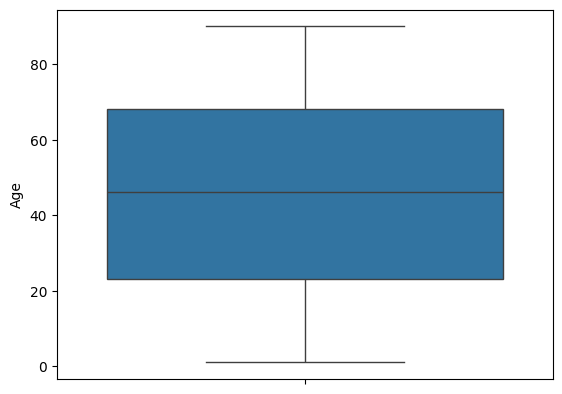

In [87]:
# boxplots
import seaborn as sns

def create_boxplot(data,column_name,hue=None):
    sns.boxplot(data=data, y=column_name, hue=hue)
    
create_boxplot(df , "Age")

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98619 entries, 0 to 98618
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Gender                98619 non-null  object
 1   Age                   98619 non-null  int64 
 2   Nationality           98619 non-null  object
 3   Airport Name          98619 non-null  object
 4   Airport Country Code  98619 non-null  object
 5   Country Name          98619 non-null  object
 6   Airport Continent     98619 non-null  object
 7   Continents            98619 non-null  object
 8   Arrival Airport       98619 non-null  object
 9   Flight Status         98619 non-null  object
 10  Year of Depature      98619 non-null  int32 
 11  Month of Depature     98619 non-null  int32 
 12  Day of Depature       98619 non-null  int32 
dtypes: int32(3), int64(1), object(9)
memory usage: 8.7+ MB


### Feature Enginerring

In [89]:
# Train Test Split
y = df['Flight Status']
X = df.drop(columns=['Flight Status'])
X_train, X_test, y_train , y_test = train_test_split(X , y , test_size= 0.2 , random_state= 42)

In [106]:
# Creating Pipeline for each Columns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import pandas as pd

# Numerical Features Pipeline
age_pipeline = Pipeline(steps=[
    ("scaler", MinMaxScaler())
])

year_pipeline = Pipeline(steps=[
    ("scaler", MinMaxScaler())
])

month_pipeline = Pipeline(steps=[
    ("scaler", MinMaxScaler())
])

day_pipeline = Pipeline(steps=[
    ("scaler", MinMaxScaler())
])

# One-Hot Encoding Pipelines
gender_pipeline = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

airport_continent_pipeline = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

continents_pipeline = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# Frequency Encoding Pipelines
nationality_pipeline = Pipeline(steps=[
    ("freq_encoder_natio", CountFrequencyEncoder(encoding_method='count'))
])

airport_name_pipeline = Pipeline(steps=[
    ("freq_encoder_air_name", CountFrequencyEncoder(encoding_method='count'))
])

airport_country_code_pipeline = Pipeline(steps=[
    ("freq_encoder_air_coun", CountFrequencyEncoder(encoding_method='count'))
])

country_name_pipeline = Pipeline(steps=[
    ("freq_encoder+count_name", CountFrequencyEncoder(encoding_method='count'))
])

arrival_airport_pipeline = Pipeline(steps=[
    ("freq_encoder_arrival_name", CountFrequencyEncoder(encoding_method='count'))
])


#### Columns Transformer

In [99]:
from sklearn import set_config
set_config(transform_output="pandas")

In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98619 entries, 0 to 98618
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Gender                98619 non-null  object
 1   Age                   98619 non-null  int64 
 2   Nationality           98619 non-null  object
 3   Airport Name          98619 non-null  object
 4   Airport Country Code  98619 non-null  object
 5   Country Name          98619 non-null  object
 6   Airport Continent     98619 non-null  object
 7   Continents            98619 non-null  object
 8   Arrival Airport       98619 non-null  object
 9   Flight Status         98619 non-null  object
 10  Year of Depature      98619 non-null  int32 
 11  Month of Depature     98619 non-null  int32 
 12  Day of Depature       98619 non-null  int32 
dtypes: int32(3), int64(1), object(9)
memory usage: 8.7+ MB


In [108]:
# Defining ColumnTransformer
preprocessing = ColumnTransformer(transformers=[
    ("age", age_pipeline, ['Age']),
    ("year", year_pipeline, ['Year of Depature']),
    ("month", month_pipeline, ['Month of Depature']),
    ("day", day_pipeline, ['Day of Depature']),
    ("gender", gender_pipeline, ['Gender']),
    ("airport_continent", airport_continent_pipeline, ['Airport Continent']),
    ("continents", continents_pipeline, ['Continents']),
    ("nationality", nationality_pipeline, ['Nationality']),
    ("airport_name", airport_name_pipeline, ['Airport Name']),
    ("airport_country_code", airport_country_code_pipeline, ['Airport Country Code']),
    ("country_name", country_name_pipeline, ['Country Name']),
    ("arrival_airport", arrival_airport_pipeline, ['Arrival Airport'])
], remainder="passthrough" , n_jobs=-1)
preprocessing

ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('age',
                                 Pipeline(steps=[('scaler', MinMaxScaler())]),
                                 ['Age']),
                                ('year',
                                 Pipeline(steps=[('scaler', MinMaxScaler())]),
                                 ['Year of Depature']),
                                ('month',
                                 Pipeline(steps=[('scaler', MinMaxScaler())]),
                                 ['Month of Depature']),
                                ('day',
                                 Pipeline(steps=[('scaler', MinMaxScaler())]),
                                 ['Day of Depature']),
                                ('gender...
                                                  CountFrequencyEncoder())]),
                                 ['Airport Name']),
                                ('airport_country_code',
                                 Pipeline(steps=[('freq_encoder_air_coun',
                                                  CountFrequencyEncoder())]),
                                 ['Airport Country Code']),
                                ('country_name',
                                 Pipeline(steps=[('freq_encoder+count_name',
                                                  CountFrequencyEncoder())]),
                                 ['Country Name']),
                                ('arrival_airport',
                                 Pipeline(steps=[('freq_encoder_arrival_name',
                                                  CountFrequencyEncoder())]),
                                 ['Arrival Airport'])])

In [109]:
temp = preprocessing.fit_transform(X_train)

In [113]:
model_params = {'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': 0.8,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 300,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 30,
 'verbose': 0,
 'warm_start': False}

In [115]:

model_pipe = Pipeline(steps=[
    ('preprocessor',preprocessing),
    ('clf',RandomForestClassifier(**model_params))
])

model_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('age',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Age']),
                                                 ('year',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Year of Depature']),
                                                 ('month',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Month of Depature']),
                                                 ('day',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler(...
                                                                   CountFrequencyEncoder())]),
                                                  ['Airport Country Code']),
                                                 ('country_name',
                                                  Pipeline(steps=[('freq_encoder+count_name',
                                                                   CountFrequencyEncoder())]),
                                                  ['Country Name']),
                                                 ('arrival_airport',
                                                  Pipeline(steps=[('freq_encoder_arrival_name',
                                                                   CountFrequencyEncoder())]),
                                                  ['Arrival Airport'])])),
                ('clf',
                 RandomForestClassifier(max_depth=6, max_samples=0.8,
                                        n_estimators=300, n_jobs=-1,
                                        random_state=30))])

In [117]:
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

In [119]:
model_pipe.fit(X_train , y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('age',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Age']),
                                                 ('year',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Year of Depature']),
                                                 ('month',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Month of Depature']),
                                                 ('day',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler(...
                                                                   CountFrequencyEncoder())]),
                                                  ['Airport Country Code']),
                                                 ('country_name',
                                                  Pipeline(steps=[('freq_encoder+count_name',
                                                                   CountFrequencyEncoder())]),
                                                  ['Country Name']),
                                                 ('arrival_airport',
                                                  Pipeline(steps=[('freq_encoder_arrival_name',
                                                                   CountFrequencyEncoder())]),
                                                  ['Arrival Airport'])])),
                ('clf',
                 RandomForestClassifier(max_depth=6, max_samples=0.8,
                                        n_estimators=300, n_jobs=-1,
                                        random_state=30))])

In [128]:
# evaluate the model on the test data
from sklearn.metrics import precision_score , recall_score , f1_score, ConfusionMatrixDisplay
y_pred = model_pipe.predict(X_test)

accuracy = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred , average= "weighted")
recall = recall_score(y_test,y_pred , average="weighted")
f1 = f1_score(y_test,y_pred, average="weighted")
confusion_matr = confusion_matrix(y_test , y_pred)


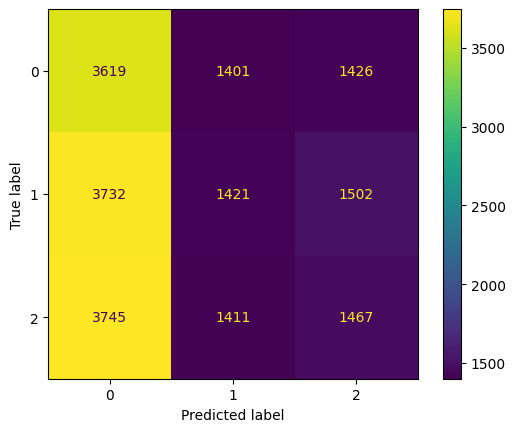

In [ ]:
accuracy , precision , recall , f1
cm = ConfusionMatrixDisplay.from_predictions(y_test , y_pred)
cm

In [130]:
model_pipe.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(n_jobs=-1, remainder='passthrough',
                     transformers=[('age',
                                    Pipeline(steps=[('scaler', MinMaxScaler())]),
                                    ['Age']),
                                   ('year',
                                    Pipeline(steps=[('scaler', MinMaxScaler())]),
                                    ['Year of Depature']),
                                   ('month',
                                    Pipeline(steps=[('scaler', MinMaxScaler())]),
                                    ['Month of Depature']),
                                   ('day',
                                    Pipeline(steps=[('scaler', MinMaxScaler())]),
                                    ['Day of Depature']),
                                   ('gender...
                                                     CountFrequencyEncoder())]),
                                    ['Airpor

In [131]:
mf.is_tracking_uri_set()

False

## Run all Mlflow retalted tracking code in a single cell

In [ ]:
#Start tracking